In [1]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNet 
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#import random

scaler = StandardScaler()
zca = zca.ZCA()

In [2]:
numCV = 10
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
target = 'Poverty'
exclude = 'States'

cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.01)

seed_ = 3

#random.seed(11)

seed(seed_)

In [3]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [4]:
all_data = pd.read_csv('../data/raw/states.csv')


In [5]:

train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference(target)].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = all_data.loc[:, ~all_data.columns.isin([exclude,target])].loc[train].copy()
X_valid = all_data.loc[:, ~all_data.columns.isin([exclude,target])].loc[valid].copy()
X_test = all_data.loc[:, ~all_data.columns.isin([exclude,target])].loc[test].copy()

y_train = y.loc[X_train.index][target].copy()
y_valid = y.loc[X_valid.index][target].copy()
y_test = y.loc[X_test.index][target].copy()

scaler.fit(np.array(y_train).reshape(-1, 1))
y_train_scaled = pd.DataFrame(scaler.transform(np.array(y_train).reshape(-1, 1)))
y_train_scaled.index = y_train.index
y_train_scaled.columns = [target]
#pd.DataFrame([i[0] for i in scaler.transform(np.array(y_train).reshape(-1, 1))])

In [6]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(X_train.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(X_train, y_train)


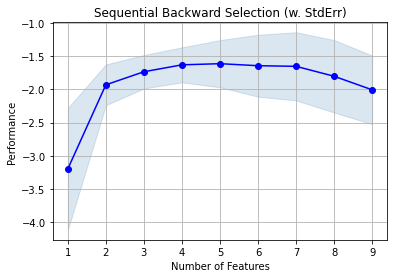

In [7]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [8]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)

In [9]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()

In [10]:
pd.DataFrame(sfbs1.subsets_).T[['avg_score','feature_names']]

,avg_score,feature_names
1,-3.200484,"(Income,)"
2,-1.929846,"(White, Income)"
3,-1.73249,"(White, Unemployed, Income)"
4,-1.628116,"(Infant Mort, White, Unemployed, Income)"
5,-1.610624,"(White, Crime, Unemployed, Income, Population)"
6,-1.64132,"(White, Crime, Traf Deaths, Unemployed, Income..."
7,-1.650743,"(White, Crime, Doctors, Traf Deaths, Unemploye..."
8,-1.800656,"(White, Crime, Doctors, Traf Deaths, Universit..."
9,-2.005178,"(Infant Mort, White, Crime, Doctors, Traf Deat..."


In [11]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sfbs1.subsets_).loc['feature_names'])[ss_position])

In [12]:
print(ss_sortedFeatures)

['White', 'Crime', 'Unemployed', 'Income', 'Population']


In [13]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(X_train[list(np.asarray(f))])
    y_ = y_train_scaled
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

('Income',)
alpha: 100.000000
l1_ratio_: 0.990000
Mean MAE: 0.455 (0.135)
('White', 'Income')
alpha: 0.000000
l1_ratio_: 0.050000
Mean MAE: 0.383 (0.082)
('White', 'Unemployed', 'Income')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.373 (0.081)
('Infant Mort', 'White', 'Unemployed', 'Income')
alpha: 0.100000
l1_ratio_: 0.000000
Mean MAE: 0.356 (0.105)
('White', 'Crime', 'Unemployed', 'Income', 'Population')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.382 (0.152)
('White', 'Crime', 'Traf Deaths', 'Unemployed', 'Income', 'Population')
alpha: 0.100000
l1_ratio_: 0.000000
Mean MAE: 0.368 (0.157)
('White', 'Crime', 'Doctors', 'Traf Deaths', 'Unemployed', 'Income', 'Population')
alpha: 0.100000
l1_ratio_: 0.000000
Mean MAE: 0.386 (0.158)
('White', 'Crime', 'Doctors', 'Traf Deaths', 'University', 'Unemployed', 'Income', 'Population')
alpha: 1.000000
l1_ratio_: 0.000000
Mean MAE: 0.376 (0.159)
('Infant Mort', 'White', 'Crime', 'Doctors', 'Traf Deaths', 'University', 'Unemployed', 'Incom

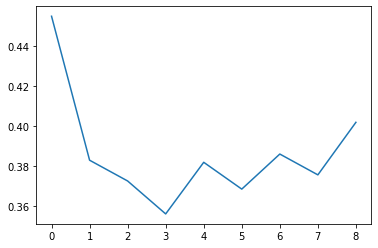

['Infant Mort' 'White' 'Unemployed' 'Income']
['White' 'Income']


,features,mean error,std,alpha,lambda
0,[Income],0.454955,0.134838,100.00,0.99
1,"[White, Income]",0.382937,0.081914,0.00,0.05
2,"[White, Unemployed, Income]",0.372543,0.081065,0.01,0.00
3,"[Infant Mort, White, Unemployed, Income]",0.356068,0.105415,0.10,0.00
4,"[White, Crime, Unemployed, Income, Population]",0.381892,0.151773,0.01,0.00
5,"[White, Crime, Traf Deaths, Unemployed, Income...",0.368476,0.156894,0.10,0.00
6,"[White, Crime, Doctors, Traf Deaths, Unemploye...",0.386020,0.157728,0.10,0.00
7,"[White, Crime, Doctors, Traf Deaths, Universit...",0.375605,0.159331,1.00,0.00
8,"[Infant Mort, White, Crime, Doctors, Traf Deat...",0.401892,0.167012,10.00,0.00


In [14]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [15]:
ss_sortedFeatures

['White', 'Crime', 'Unemployed', 'Income', 'Population']

In [16]:
model_ss = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(X_train[ss_sortedFeatures], y_train_scaled)
model_ep.fit(X_train[parse['features']],y_train_scaled)
model_eb.fit(X_train[best['features']],y_train_scaled)

ElasticNet(alpha=0.1, l1_ratio=0.0)

In [17]:
zca_X_train = pd.DataFrame(zca.fit_transform(X_train[ss_sortedFeatures]),columns=ss_sortedFeatures)
zca_X_train.index = X_train.index
zca_data = pd.concat([y_train_scaled,zca_X_train],axis=1)
zca_data.index = X_train.index

In [18]:
zca_data.pcorr()

,Poverty,White,Crime,Unemployed,Income,Population
Poverty,1.000000,-0.611998,0.366216,0.285193,-0.922362,0.166737
White,-0.611998,1.000000,0.224124,0.174538,-0.564484,0.102043
Crime,0.366216,0.224124,1.000000,-0.104442,0.337784,-0.061062
Unemployed,0.285193,0.174538,-0.104442,1.000000,0.263052,-0.047552
Income,-0.922362,-0.564484,0.337784,0.263052,1.000000,0.153792
Population,0.166737,0.102043,-0.061062,-0.047552,0.153792,1.000000


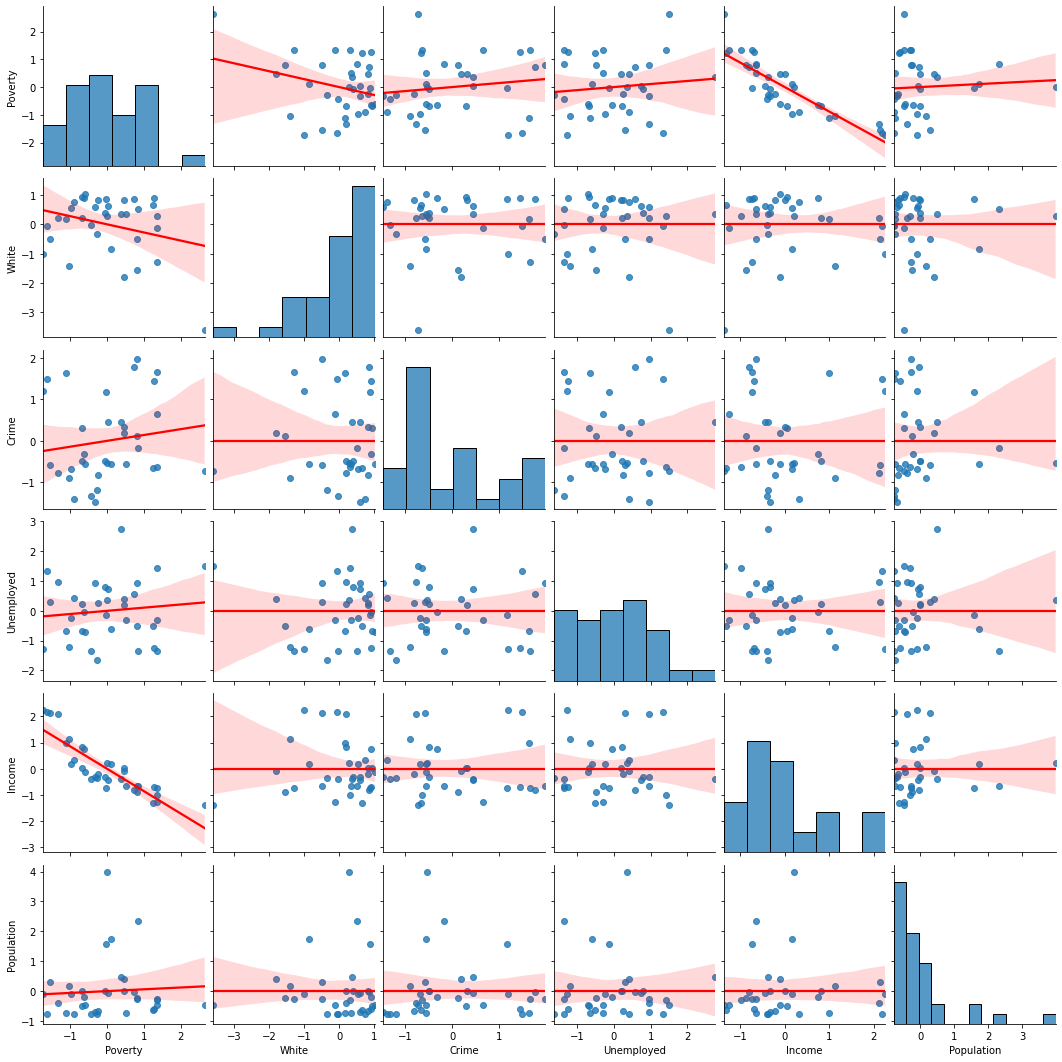

In [19]:
sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [20]:
#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
#y_ = data_set_wConstant[target]
X_trainwConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y_train_scaled,X_trainwConstant)
results = model.fit()
fitted = results.predict(X_trainwConstant)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     38.11
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           6.89e-12
Time:                        21:24:20   Log-Likelihood:                -14.237
No. Observations:                  35   AIC:                             40.47
Df Residuals:                      29   BIC:                             49.81
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.388e-16      0.067  -2.06e-15      1.000      -0.138       0.138
White         -0.2853      0.068     -4.167      0.000      -0.425      -0.145
Crime          0.1451      0.068      2.119      0.043       0.005       0.285
Unemployed     0.1097      0.068      1.602      0.120      -0.030       0.250
Income        -0.8804      0.068    -12.857      0.000      -1.020      -0.740
Population     0.0624      0.068      0.911      0.370      -0.078       0.202
==============================================================================
Omnibus:                        1.899   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.770
Skew:                           0.494   Prob(JB):                        0.413
Kurtosis:                       2.513   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

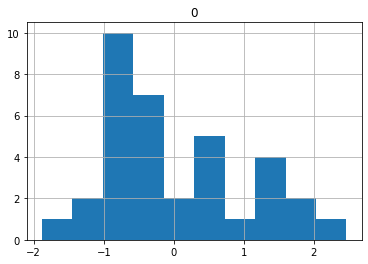

In [21]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     38.11
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           6.89e-12
Time:                        21:24:21   Log-Likelihood:                -14.237
No. Observations:                  35   AIC:                             40.47
Df Residuals:                      29   BIC:                             49.81
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.388e-16      0.

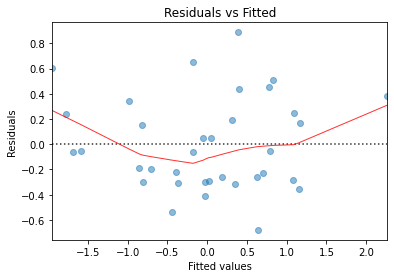

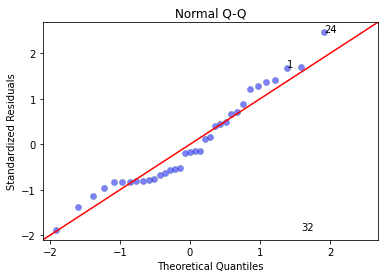

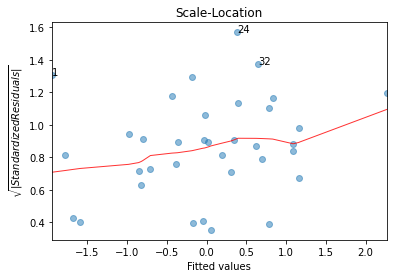

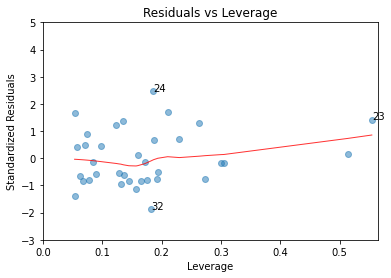

In [22]:
linear_plot = Plot.LinearRegressionResidualPlot(X_trainwConstant.values, y_train_scaled.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


[1.]
[0.]


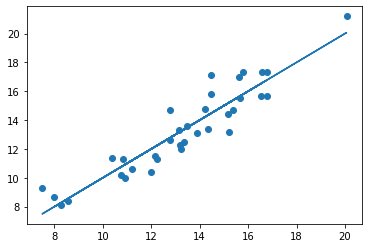

In [23]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0])

m, b = np.polyfit(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], m*results.fittedvalues*scaler.scale_[0] + scaler.mean_[0] + b)
print(m)
print(b)

Mean Absolute Error
Poverty    0.309918
dtype: float64


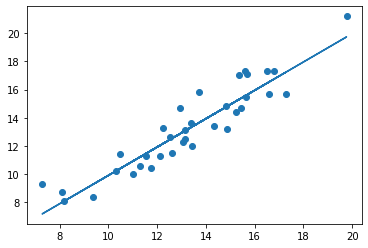

In [24]:
#model_Best = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

ENBestResults = model_eb.fit(X_train[best['features']], y_train_scaled)
ENBestFitted = ENBestResults.predict(X_train[best['features']])

yhat = pd.DataFrame(model_eb.predict(X_train[best['features']]))
yhat.index = X_train.index
yhat.columns = ['Poverty']

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(yhat-pd.DataFrame(y_train_scaled))))

plt.scatter(ENBestFitted*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*scaler.scale_[0] + scaler.mean_[0])
m, b = np.polyfit(ENBestFitted*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(ENBestFitted*scaler.scale_[0] + scaler.mean_[0], m*ENBestFitted*scaler.scale_[0] + scaler.mean_[0] + b)

Mean Absolute Error
Poverty    0.365286
dtype: float64


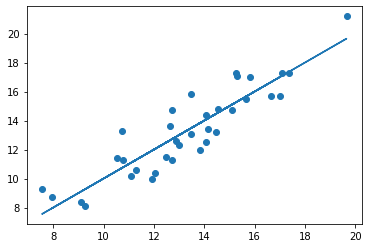

In [25]:
#model_Parse = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])

ENParseResults = model_ep.fit(X_train[parse['features']], y_train_scaled)
ENParseFitted = ENParseResults.predict(X_train[parse['features']])

yhat = pd.DataFrame(model_ep.predict(X_train[parse['features']]))
yhat.index = X_train.index
yhat.columns = ['Poverty']

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(yhat-pd.DataFrame(y_train_scaled))))

plt.scatter(ENParseFitted*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*scaler.scale_[0] + scaler.mean_[0])
m, b = np.polyfit(ENParseFitted*scaler.scale_[0] + scaler.mean_[0], y_train_scaled*scaler.scale_[0] + scaler.mean_[0], 1)
plt.plot(ENParseFitted*scaler.scale_[0] + scaler.mean_[0], m*ENParseFitted*scaler.scale_[0] + scaler.mean_[0] + b)

Mean MAE: 0.358 (0.109)


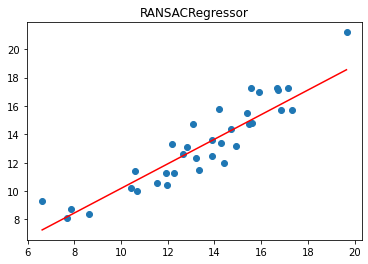

Mean MAE: 0.400 (0.094)


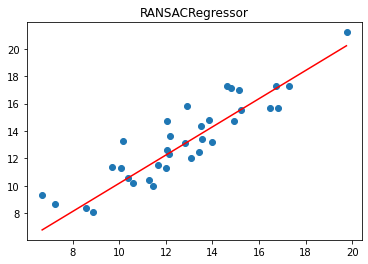

Mean MAE: 0.428 (0.134)


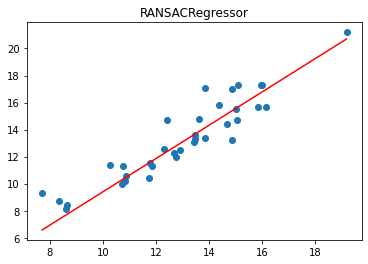

In [26]:
#robust regression using best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(X_train[best['features']], y_train_scaled, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(X_train[best['features']],y_train_scaled)
RFitted_best = model_rr_best.predict(X_train[best['features']])
y_valid_rr_best_fitted = model_rr_best.predict(X_valid[best['features']])
plot_best_fit(RFitted_best.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*scaler.scale_[0] + scaler.mean_[0], model_rr_best)

#robust regression using parse
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(X_train[parse['features']], y_train_scaled, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(X_train[parse['features']],y_train_scaled)
RFitted_parse = model_rr_parse.predict(X_train[parse['features']])
y_valid_rr_parse_fitted = model_rr_parse.predict(X_valid[parse['features']])
plot_best_fit(RFitted_parse.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*scaler.scale_[0] + scaler.mean_[0], model_rr_parse)

#robust regression using ss
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
Rresults_ss = evaluate_model(X_train[ss_sortedFeatures], y_train_scaled, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
Rresults_ss = model_rr_ss.fit(X_train[ss_sortedFeatures],y_train_scaled)
RFitted_ss = model_rr_ss.predict(X_train[ss_sortedFeatures])
y_valid_rr_ss_fitted = model_rr_ss.predict(X_valid[ss_sortedFeatures])
plot_best_fit(RFitted_ss.reshape(-1, 1)*scaler.scale_[0] + scaler.mean_[0],y_train_scaled*scaler.scale_[0] + scaler.mean_[0], model_rr_parse)

In [27]:
y_valid_ss_fitted = model_ss.predict(X_valid[ss_sortedFeatures])
y_valid_eb_fitted = model_eb.predict(X_valid[best['features']])
y_valid_ep_fitted = model_ep.predict(X_valid[parse['features']])

In [28]:
y_valid_scaled = scaler.transform(np.array(y_valid).reshape(-1, 1))

In [29]:
print("OLS SS: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_ss_fitted))))
print("EN best: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_ep_fitted))))

print("RR SS: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_ss_fitted))))
print("RR best: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(y_valid_scaled)-y_valid_rr_parse_fitted))))

OLS SS: 0.3338527174005378
EN best: 1.0445785085266852
EN parse: 1.0412928559744081
RR SS: 0.2966605243243535
RR best: 0.35313806470174974
RR parse: 0.2726605943319226
